In [1]:
import os
import cv2
from deepface import DeepFace
#from deepface.modules import functions
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
from time import time

# Local descriptors
from skimage.feature import hog, local_binary_pattern
from skimage import  exposure
from skimage import feature

# Classifiers
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from collections import defaultdict

In [2]:
def GetPredictions(X_train, X_test, y_train, y_test, model, parameters):
    model_name = type(model).__name__
    print(f"{model_name} training...")
    t0 = time()
    
    # Grid search across parameter range
    clf = GridSearchCV(model, parameters, cv=5)
    clf = clf.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)

    print("Predicting")
    t0 = time()
    # test labels
    y_pred = clf.predict(X_test)
   
    print("done in %0.3fs" % (time() - t0))
    
    return y_pred, y_test

In [3]:
def calc_embs(model, X):
    norm_images = prewhiten(X)
    pd = []
    for image in norm_images:
        pd.append(model.forward(np.expand_dims(image, axis=0)))
    return l2_normalize(np.concatenate(pd))

def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

def prewhiten(x):
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std_adj
    return y

In [4]:
def save_image_with_error_handling(dest_folder, class_name, n_images, image):
    try:
        cv2.imwrite(os.path.join(dest_folder, os.path.join(class_name, str(n_images) + '_faces.jpg')), image)
    except cv2.error as e:
        print(f"An error occurred while saving image {str(n_images)}: {e}")

In [6]:
def preprocess_image_for_facenet(image):
    """
    Preprocesses an image for FaceNet model:
    - Resizes the image to the expected input size of the model (160x160).
    - Applies histogram equalization for contrast enhancement.
    - Applies sharpening filter to enhance details.
    - Normalizes image values to the range [-1, 1].
    
    Args:
    - image: Input image.
    
    Returns:
    - preprocessed_image: Preprocessed image.
    """
    # Scaling to the expected input size of the model (160x160)
    target_size = (160, 160)
    resized_image = cv2.resize(image, target_size)
    
    # Histogram equalization for contrast enhancement
    if len(resized_image.shape) == 3 and resized_image.shape[2] == 3:
        ycrcb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2YCrCb)
        channels = cv2.split(ycrcb)
        cv2.equalizeHist(channels[0], channels[0])
        cv2.merge(channels, ycrcb)
        resized_image = cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2BGR)
    else:
        resized_image = cv2.equalizeHist(resized_image)
    
    # Sharpening the images
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    sharpened_image = cv2.filter2D(resized_image, -1, kernel)
    
    # Normalizing image values to the range [-1, 1]
    normalized_image = sharpened_image / 127.5 - 1
    
    return normalized_image

# Face detection and alignment without dlib
def align_face(image):
    """
    Detects and aligns face in the image.
    
    Args:
    - image: Input image.
    
    Returns:
    - face_roi: Cropped face region of interest.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    faces = faceCascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5, minSize=(30, 30))
    
    if len(faces) > 0:
        x, y, w, h = faces[0]
        face_roi = image[y:y + h, x:x + w]
        return face_roi
    else:
        return image

def save_image_with_error_handling(dest_folder, class_name, n_images, image):
    """
    Saves an image with error handling.
    
    Args:
    - dest_folder: Destination folder for saving the image.
    - class_name: Name of the class (subfolder).
    - n_images: Image index.
    - image: Image to be saved.
    """
    try:
        os.makedirs(os.path.join(dest_folder, class_name), exist_ok=True)
        cv2.imwrite(os.path.join(dest_folder, class_name, str(n_images) + '_faces.jpg'), image)
    except cv2.error as e:
        print(f"An error occurred while saving image {str(n_images)}: {e}")

# Data location
folder = "data/rvf10k/train"
dest_folder = "data/roi_dataset"
cascade_path = "data/haarcascade_frontalface_default.xml"

# Counter for the number of classes in the dataset
nclasses = 0
# Counter for samples per class
nperclass = []
# Label for each class (name of the subfolder)
classlabels = []

n_images = 0

# Assumes that there is a subfolder per class in the given path
for class_name in os.listdir(folder):
    # Each subfolder implies one more class
    nclasses += 1
    # Initially, this class has no samples
    nsamples = 0

    # Compose the path
    class_folder = os.path.join(folder, class_name)
    for file_name in os.listdir(class_folder):
        # Assumes images are in jpg format
        if file_name.endswith('.jpg'):
            # Read the image
            image = cv2.imread(os.path.join(class_folder, file_name))

            # Extract face as ROI
            faceCascade = cv2.CascadeClassifier(cascade_path)
            faces = faceCascade.detectMultiScale(
                image,
                scaleFactor=1.3,
                minNeighbors=5,
                minSize=(30, 30)
            )

            if len(faces) > 0:
                for x, y, w, h in faces:
                    face_roi = image[y:y + h, x:x + w]
                    aligned_face = align_face(face_roi)
                    preprocessed_face = preprocess_image_for_facenet(aligned_face)
                    save_image_with_error_handling(dest_folder, class_name, n_images, preprocessed_face)
                    n_images += 1
            else:
                aligned_image = align_face(image)
                preprocessed_image = preprocess_image_for_facenet(aligned_image)
                cv2.imwrite(
                    os.path.join(dest_folder, os.path.join(class_name, str(n_images) + '_faces.jpg')), preprocessed_image)
                n_images += 1

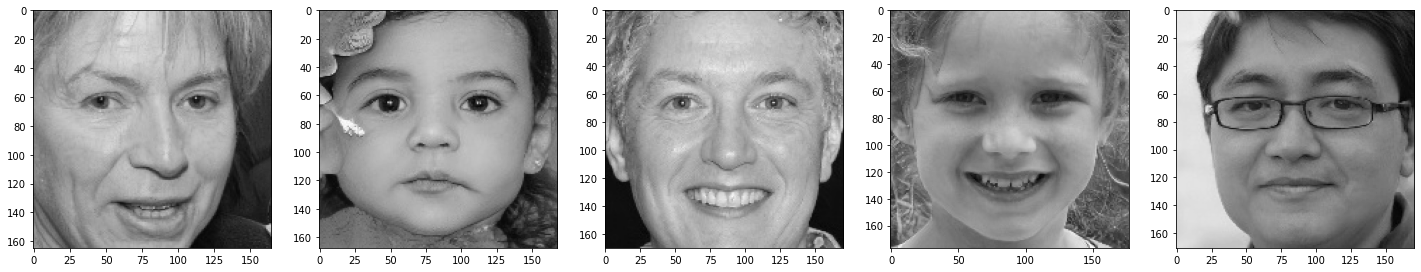

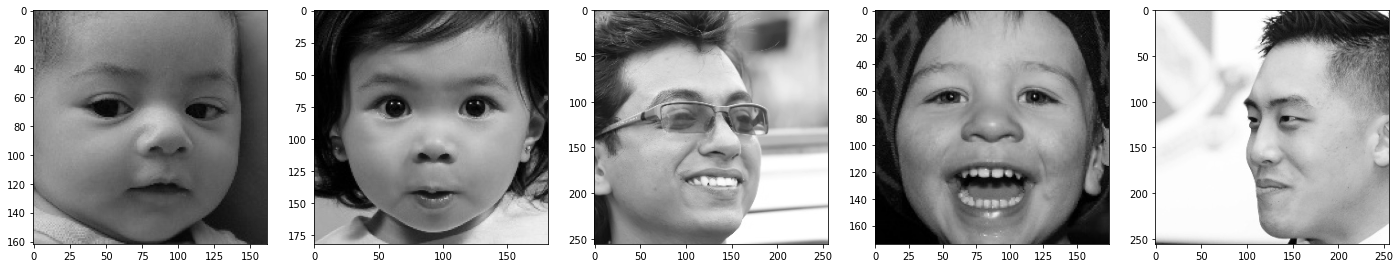

Features
(7006,)
(7006,)


In [7]:
# Deepface
# Available models ['VGG-Face', 'Facenet', 'OpenFace', 'DeepFace', 'DeepID', 'Dlib']
model_deepface = DeepFace.build_model("Facenet512")

target_size = (model_deepface.input_shape[0], model_deepface.input_shape[1])
dim = (int(target_size[0]), int(target_size[1]))

# Data location
folder = "data/roi_dataset"

# Counter for the number of classes in the dataset
nclasses = 0
# Counter for samples per class
nperclass = []
# Label for each class (name of the subfolder)
classlabels = []
# Initialize data structures and their corresponding labels
X = []
Y = []
XFaceNet = []

# Default resolution value for matplotlib
dpi = matplotlib.rcParams['figure.dpi']
# Number of sample images from each class to show
nims2show = 5

# Assumes that there is a subfolder per class in the given path
for class_name in os.listdir(folder):
    # Each subfolder implies one more class
    nclasses += 1
    # Initially, this class has no samples
    nsamples = 0

    # Compose the path
    class_folder = os.path.join(folder, class_name)
    for file_name in os.listdir(class_folder):
        # Assumes images are in jpg format
        if file_name.endswith('.jpg'):
            # Read the image
            image = cv2.imread(os.path.join(class_folder, file_name))
            
            # Extract sizes
            height, width, depth = image.shape
            # Convert to grayscale
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            X.append(gray.reshape(height * width))
            
            # Deepface with FaceNet
            # Get embeddings
            img_embedding = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
            img_embedding = calc_embs(model_deepface, np.expand_dims(img_embedding, axis=0))
            XFaceNet.append(img_embedding[0])
                    
            # Add numerical label of the sample
            Y.append(nclasses - 1)
            
            # Show the first nims2show samples of each class
            if nsamples < nims2show:
                if nsamples == 0:
                    figsize = 15 * width / float(dpi), 15 * height / float(dpi)
                    fig = plt.figure(figsize=figsize)
                
                fig.add_subplot(1, nims2show, nsamples + 1)
                plt.imshow(gray, cmap='gray', vmin=0, vmax=255)
            
            # Increase the number of samples
            nsamples += 1
    plt.show()
    nperclass.append(nsamples)
    classlabels.append(class_name)
    
# Convert X and Y to numpy arrays
Y = np.array(Y, dtype='float64')
XFaceNet = np.array(XFaceNet, dtype='float32')

# Show information about the read dataset
# Debugging
print("Features")
print(XFaceNet.shape)
print(Y.shape)
# Get number of samples and features
# Get names of the classes
class_names = np.array(classlabels)
n_classes = class_names.shape[0]

In [8]:
# StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=7, shuffle=True)

fold = 1
for train_index, test_index in skf.split(X, Y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    print("Fold %d" % fold)
    print("# samples in training set %d" % train_index.shape[0])
    print("# samples in test set %d" % test_index.shape[0])
    fold += 1

Fold 1
# samples in training set 5604
# samples in test set 1402
Fold 2
# samples in training set 5605
# samples in test set 1401
Fold 3
# samples in training set 5605
# samples in test set 1401
Fold 4
# samples in training set 5605
# samples in test set 1401
Fold 5
# samples in training set 5605
# samples in test set 1401


+++++++++++++++++++++++++++++++++++++++++++

*********************
Fold 1

Deepface/Facenet
SVC training...
done in 49.270s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.0005)
Predicting
done in 0.550s

Deepface/Facenet + SVM Metrics
              precision    recall  f1-score   support

        fake       0.53      0.63      0.58       701
        real       0.54      0.44      0.49       701

    accuracy                           0.54      1402
   macro avg       0.54      0.54      0.53      1402
weighted avg       0.54      0.54      0.53      1402

Confusion matrix for Facenet + SVM:
[[443 258]
 [393 308]]


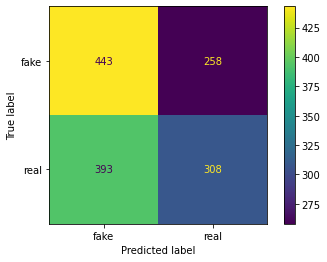

RandomForestClassifier training...
done in 22.001s
Best estimator found by grid search:
RandomForestClassifier()
Predicting
done in 0.031s

Deepface/Facenet + RF Metrics
              precision    recall  f1-score   support

        fake       0.49      0.49      0.49       701
        real       0.50      0.50      0.50       701

    accuracy                           0.50      1402
   macro avg       0.50      0.50      0.49      1402
weighted avg       0.50      0.50      0.49      1402

Confusion matrix for Facenet + RF:
[[342 359]
 [349 352]]


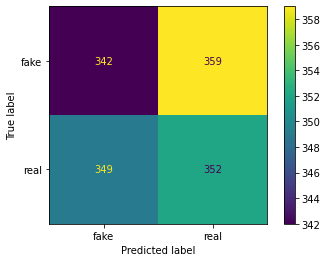

*********************
Fold 2

Deepface/Facenet
SVC training...
done in 47.745s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.0005)
Predicting
done in 0.641s

Deepface/Facenet + SVM Metrics
              precision    recall  f1-score   support

        fake       0.51      0.62      0.56       701
        real       0.51      0.40      0.45       700

    accuracy                           0.51      1401
   macro avg       0.51      0.51      0.50      1401
weighted avg       0.51      0.51      0.50      1401

Confusion matrix for Facenet + SVM:
[[433 268]
 [418 282]]


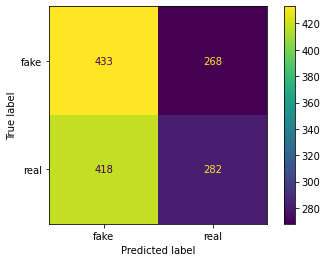

RandomForestClassifier training...
done in 21.434s
Best estimator found by grid search:
RandomForestClassifier(n_estimators=200)
Predicting
done in 0.071s

Deepface/Facenet + RF Metrics
              precision    recall  f1-score   support

        fake       0.48      0.45      0.46       701
        real       0.48      0.51      0.49       700

    accuracy                           0.48      1401
   macro avg       0.48      0.48      0.48      1401
weighted avg       0.48      0.48      0.48      1401

Confusion matrix for Facenet + RF:
[[315 386]
 [344 356]]


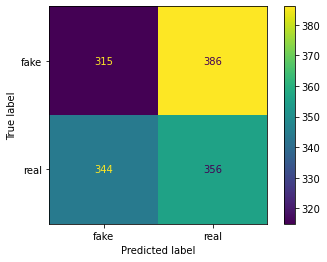

*********************
Fold 3

Deepface/Facenet
SVC training...
done in 45.796s
Best estimator found by grid search:
SVC(C=5000.0, class_weight='balanced', gamma=0.0005)
Predicting
done in 0.542s

Deepface/Facenet + SVM Metrics
              precision    recall  f1-score   support

        fake       0.53      0.60      0.57       700
        real       0.55      0.48      0.51       701

    accuracy                           0.54      1401
   macro avg       0.54      0.54      0.54      1401
weighted avg       0.54      0.54      0.54      1401

Confusion matrix for Facenet + SVM:
[[422 278]
 [368 333]]


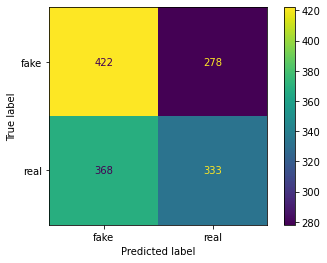

RandomForestClassifier training...
done in 21.697s
Best estimator found by grid search:
RandomForestClassifier(n_estimators=150)
Predicting
done in 0.031s

Deepface/Facenet + RF Metrics
              precision    recall  f1-score   support

        fake       0.48      0.47      0.48       700
        real       0.48      0.49      0.49       701

    accuracy                           0.48      1401
   macro avg       0.48      0.48      0.48      1401
weighted avg       0.48      0.48      0.48      1401

Confusion matrix for Facenet + RF:
[[332 368]
 [356 345]]


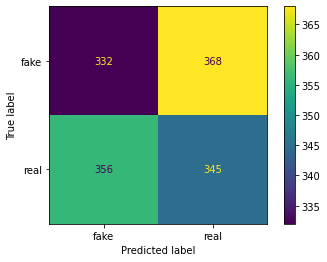

*********************
Fold 4

Deepface/Facenet
SVC training...
done in 46.016s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.001)
Predicting
done in 0.501s

Deepface/Facenet + SVM Metrics
              precision    recall  f1-score   support

        fake       0.53      0.61      0.57       700
        real       0.55      0.47      0.50       701

    accuracy                           0.54      1401
   macro avg       0.54      0.54      0.54      1401
weighted avg       0.54      0.54      0.54      1401

Confusion matrix for Facenet + SVM:
[[429 271]
 [375 326]]


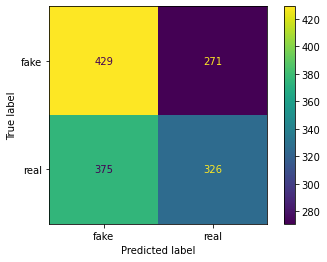

RandomForestClassifier training...
done in 20.302s
Best estimator found by grid search:
RandomForestClassifier()
Predicting
done in 0.016s

Deepface/Facenet + RF Metrics
              precision    recall  f1-score   support

        fake       0.51      0.53      0.52       700
        real       0.51      0.49      0.50       701

    accuracy                           0.51      1401
   macro avg       0.51      0.51      0.51      1401
weighted avg       0.51      0.51      0.51      1401

Confusion matrix for Facenet + RF:
[[371 329]
 [361 340]]


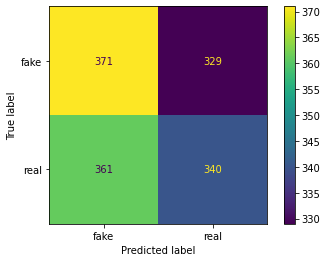

*********************
Fold 5

Deepface/Facenet
SVC training...
done in 46.514s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.001)
Predicting
done in 0.588s

Deepface/Facenet + SVM Metrics
              precision    recall  f1-score   support

        fake       0.53      0.58      0.55       700
        real       0.54      0.49      0.51       701

    accuracy                           0.53      1401
   macro avg       0.53      0.53      0.53      1401
weighted avg       0.53      0.53      0.53      1401

Confusion matrix for Facenet + SVM:
[[405 295]
 [360 341]]


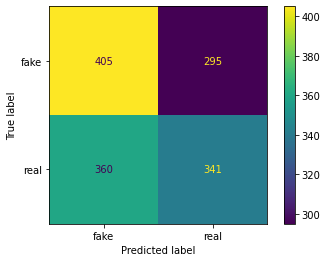

RandomForestClassifier training...
done in 21.161s
Best estimator found by grid search:
RandomForestClassifier()
Predicting
done in 0.031s

Deepface/Facenet + RF Metrics
              precision    recall  f1-score   support

        fake       0.49      0.47      0.48       700
        real       0.49      0.51      0.50       701

    accuracy                           0.49      1401
   macro avg       0.49      0.49      0.49      1401
weighted avg       0.49      0.49      0.49      1401

Confusion matrix for Facenet + RF:
[[327 373]
 [342 359]]


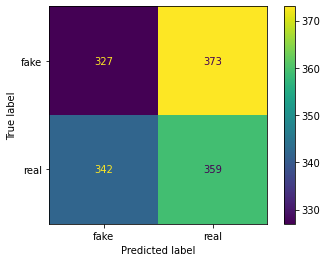

In [9]:
print("+++++++++++++++++++++++++++++++++++++++++++\n")

# KNN 
precs_facenet_svm, recs_facenet_svm, acc_facenet_svm = [], [], []

precs_facenet_rf, recs_facenet_rf, acc_facenet_rf = [], [], []

SVM = SVC(kernel='rbf', class_weight='balanced')
SVM_parameters = {
    'C': [1e3, 5e3],
    'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01],
}

RF = RandomForestClassifier()
RF_parameters = {
    'n_estimators': [100, 150, 200],
}

fold = 1
skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(X, Y):
    print("*********************\nFold %d" % fold)
        
    # Facenet - SVM
    print("\nDeepface/Facenet")
    XFaceNet = XFaceNet.reshape(-1, 1)
    y_pred, y_test = GetPredictions(XFaceNet[train_index], XFaceNet[test_index], Y[train_index], Y[test_index], SVM, SVM_parameters)
    print("\nDeepface/Facenet + SVM Metrics")
    precs_facenet_svm.append(precision_score(y_test, y_pred))
    recs_facenet_svm.append(recall_score(y_test, y_pred))
    acc_facenet_svm.append(accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=class_names))

    print("Confusion matrix for Facenet + SVM:")
    cm = confusion_matrix(y_test, y_pred, labels=range(n_classes))
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot()
    plt.show()
        
    # Facenet - Random Forest
    y_pred, y_test = GetPredictions(XFaceNet[train_index], XFaceNet[test_index], Y[train_index], Y[test_index], RF, RF_parameters)
    print("\nDeepface/Facenet + RF Metrics")
    precs_facenet_rf.append(precision_score(y_test, y_pred))
    recs_facenet_rf.append(recall_score(y_test, y_pred))
    acc_facenet_rf.append(accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=class_names))

    print("Confusion matrix for Facenet + RF:")
    cm = confusion_matrix(y_test, y_pred, labels=range(n_classes))
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot()
    plt.show()
        
    fold += 1